In [5]:
# !pip install rdkit xgboost optuna selfies pandas numpy scikit-learn matplotlib seaborn mols2grid

import os
import random
import numpy as np
import pandas as pd
import xgboost as xgb
import optuna
import selfies as sf
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, QED, DataStructs
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score

# Ustawienie ziarna losowości dla powtarzalności (ważne w publikacji!)
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Środowisko gotowe.")

Środowisko gotowe.


In [6]:
# ==========================================
# KOMÓRKA 2: POBIERANIE I PRZYGOTOWANIE DANYCH
# ==========================================

import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem

# Twój znaleziony, działający link RAW:
url = "https://raw.githubusercontent.com/postera-ai/COVID_moonshot_submissions/refs/heads/master/covid_submissions_all_info.csv"

print("Pobieranie danych Moonshot...")
try:
    df = pd.read_csv(url)
    print("Pobrano pomyślnie!")
except Exception as e:
    print(f"Błąd pobierania: {e}")
    raise

# Filtrowanie: interesują nas wiersze z wartością f_avg_IC50 i SMILES
# f_avg_IC50 to główna metryka w tym zbiorze danych
df_clean = df[['SMILES', 'f_avg_IC50']].dropna().copy()

# Usuwamy wartości ujemne lub zerowe (błędy pomiarowe)
df_clean = df_clean[df_clean['f_avg_IC50'] > 0]

# Konwersja IC50 na pIC50
# W Moonshot jednostki to zazwyczaj uM (mikromole).
# pIC50 = -log10(IC50_Molar) = -log10(IC50_uM * 10^-6)
molar_ic50 = df_clean['f_avg_IC50'] * 1e-6
df_clean['pIC50'] = -np.log10(molar_ic50)

# Ograniczamy zakres do sensownych wartości chemicznych (usuwamy artefakty)
df_clean = df_clean[(df_clean['pIC50'] > 2) & (df_clean['pIC50'] < 13)]

# Usuwanie duplikatów i błędnych SMILES
def is_valid(smiles):
    try:
        m = Chem.MolFromSmiles(smiles)
        return m is not None
    except:
        return False

df_clean = df_clean[df_clean['SMILES'].apply(is_valid)]
print(f"Dane gotowe. Liczba cząsteczek: {len(df_clean)}")

# Featurization (Morgan Fingerprints)
def get_fp(smiles):
    mol = Chem.MolFromSmiles(smiles)
    # nBits=2048 to standard w publikacjach
    return np.array(AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=2048))

print("Generowanie fingerprintów...")
X = np.array([get_fp(s) for s in df_clean['SMILES']])
y = df_clean['pIC50'].values
print("Gotowe do treningu!")

Pobieranie danych Moonshot...


/tmp/ipykernel_18224/156027699.py:15: DtypeWarning: Columns (3,6,7,9,10,11,12,13,14,15,18,19,27,28,29,30,31,32,33,34,35,36,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,66,67,69,70,71,72,73,74,75,76,84,85,86,87,89,90,91,92,93,94,95,96,104,105,106,107,109,110,111,112,113,114,115,116,124,125,126,127,129,130,131,132,133,134,135,136,144,145,146,147,149,150,151,152,153,154,155,156,164,165,166,167,169,170,171,172,173,174,175,176,184,185,186,187,189,190,191,192,193,194,195,196,204,205,206,207,209,210,211,212,213,214,215,216,224,225,226,227,229,230,231,232,233,234,235,236,244,245,246,247,249,253,254,255,256,257,258,259,275,276) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url)


Pobrano pomyślnie!
Dane gotowe. Liczba cząsteczek: 2260
Generowanie fingerprintów...
Gotowe do treningu!


In [7]:
# Definicja funkcji celu dla Optuny
def objective(trial):
    param = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'n_estimators': trial.suggest_int('n_estimators', 100, 600),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'n_jobs': -1
    }
    
    model = xgb.XGBRegressor(**param)
    
    # Walidacja krzyżowa 5-krotna (Gold Standard)
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    # Optuna minimalizuje wynik, więc używamy neg_rmse
    scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    
    return np.mean(scores)

print("Rozpoczynam optymalizację modelu Oracle (XGBoost)...")
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=30) # W ostatecznej wersji daj 50-100

print(f"Najlepsze RMSE: {study.best_value:.4f}")
print("Najlepsze parametry:", study.best_params)

# Trening finalnego modelu na całym zbiorze
oracle_model = xgb.XGBRegressor(**study.best_params)
oracle_model.fit(X, y)
print("Model Oracle wytrenowany!")

[I 2026-01-10 14:41:10,483] A new study created in memory with name: no-name-cd4810a6-342f-4ef9-be33-2c96534df588


Rozpoczynam optymalizację modelu Oracle (XGBoost)...


[I 2026-01-10 14:41:14,616] Trial 0 finished with value: 0.6070394181192806 and parameters: {'n_estimators': 419, 'max_depth': 3, 'learning_rate': 0.11216319384826776, 'subsample': 0.7524707859484596, 'colsample_bytree': 0.9448746327616977, 'min_child_weight': 4}. Best is trial 0 with value: 0.6070394181192806.
[I 2026-01-10 14:41:21,253] Trial 1 finished with value: 0.5946647995106065 and parameters: {'n_estimators': 553, 'max_depth': 10, 'learning_rate': 0.04706333902558794, 'subsample': 0.9455323116228925, 'colsample_bytree': 0.9869364015724105, 'min_child_weight': 10}. Best is trial 1 with value: 0.5946647995106065.
[I 2026-01-10 14:41:24,917] Trial 2 finished with value: 0.6215052871414866 and parameters: {'n_estimators': 246, 'max_depth': 10, 'learning_rate': 0.20733183516872, 'subsample': 0.8132961428648191, 'colsample_bytree': 0.9390794317493533, 'min_child_weight': 5}. Best is trial 1 with value: 0.5946647995106065.
[I 2026-01-10 14:41:26,884] Trial 3 finished with value: 0.60

Najlepsze RMSE: 0.5881
Najlepsze parametry: {'n_estimators': 335, 'max_depth': 9, 'learning_rate': 0.07284768107394268, 'subsample': 0.997348978266182, 'colsample_bytree': 0.8559754686684994, 'min_child_weight': 8}
Model Oracle wytrenowany!


In [8]:
def predict_pic50(smiles):
    try:
        fp = get_fp(smiles).reshape(1, -1)
        return oracle_model.predict(fp)[0]
    except:
        return 0.0

def get_fitness(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if not mol: return -10.0
    
    # 1. Przewidywana aktywność
    pic50 = predict_pic50(smiles)
    
    # 2. Drug-likeness (QED)
    qed = QED.qed(mol)
    
    # 3. Synthetic Accessibility (SA) - uproszczona jako kara za LogP/Masę
    # W pełnej publikacji warto użyć pakietu sascorer.py z RDKit Contrib
    logp = Descriptors.MolLogP(mol)
    sa_penalty = 0
    if logp > 5: sa_penalty += (logp - 5) # Kara za zbyt dużą lipofilowość
    
    # Finalny wzór fitness (możesz tu eksperymentować z wagami)
    fitness = (pic50 * 1.5) + (qed * 2.0) - (sa_penalty * 0.5)
    return fitness, pic50, qed

# Operacje genetyczne na SELFIES
def mutate_selfie(selfie, mutation_rate=0.1):
    try:
        chars = list(sf.split_selfies(selfie))
        alphabet = list(sf.get_semantic_robust_alphabet())
        
        new_chars = []
        for char in chars:
            if random.random() < mutation_rate:
                new_chars.append(random.choice(alphabet))
            else:
                new_chars.append(char)
        return "".join(new_chars)
    except:
        return selfie

def crossover_selfie(selfie1, selfie2):
    try:
        chars1 = list(sf.split_selfies(selfie1))
        chars2 = list(sf.split_selfies(selfie2))
        
        # Punkt przecięcia
        min_len = min(len(chars1), len(chars2))
        if min_len < 2: return selfie1
        
        cut = random.randint(1, min_len-1)
        new_selfie = "".join(chars1[:cut] + chars2[cut:])
        return new_selfie
    except:
        return selfie1

In [9]:
# Parametry
GENERATIONS = 30
POP_SIZE = 100
OFFSPRING_SIZE = 100

# Populacja startowa (losujemy z Moonshot lub ZINC)
initial_smiles = df_clean['SMILES'].sample(POP_SIZE).tolist()
population = []

print("Inicjalizacja populacji...")
for sm in initial_smiles:
    fit, pic, qed = get_fitness(sm)
    population.append({'smiles': sm, 'fitness': fit, 'pic50': pic, 'gen': 0})

# Sortowanie startowe
population = sorted(population, key=lambda x: x['fitness'], reverse=True)

history = [] # Do wykresów

print(f"Start GA. Najlepszy Fitness Startowy: {population[0]['fitness']:.2f}")

for gen in range(1, GENERATIONS + 1):
    # Elityzm - zachowujemy top 10%
    new_population = population[:int(POP_SIZE * 0.1)]
    
    # Generowanie potomstwa
    while len(new_population) < POP_SIZE:
        # Selekcja turniejowa
        parent1 = random.choice(population[:50])
        parent2 = random.choice(population[:50])
        
        s1 = sf.encoder(parent1['smiles'])
        s2 = sf.encoder(parent2['smiles'])
        
        # Krzyżowanie lub mutacja
        if random.random() < 0.5:
            child_s = crossover_selfie(s1, s2)
        else:
            child_s = mutate_selfie(s1)
            
        # Dekodowanie
        try:
            child_smiles = sf.decoder(child_s)
        except:
            continue
            
        # Ocena
        fit, pic, qed = get_fitness(child_smiles)
        
        # Odrzucamy duplikaty i niepoprawne cząsteczki
        if fit > -1 and child_smiles not in [p['smiles'] for p in new_population]:
            new_population.append({'smiles': child_smiles, 'fitness': fit, 'pic50': pic, 'gen': gen})
            
    population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)
    best = population[0]
    
    # Zapis statystyk
    avg_fit = np.mean([p['fitness'] for p in population])
    history.append({'gen': gen, 'best_fitness': best['fitness'], 'avg_fitness': avg_fit, 'best_pic50': best['pic50']})
    
    print(f"Gen {gen} | Best Fit: {best['fitness']:.2f} | pIC50: {best['pic50']:.2f} | SMILES: {best['smiles'][:30]}...")

print("Ewolucja zakończona.")

Inicjalizacja populacji...
Start GA. Najlepszy Fitness Startowy: 11.64
Gen 1 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 2 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 3 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 4 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 5 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 6 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 7 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 8 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 9 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 10 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 11 | Best Fit: 11.64 | pIC50: 6.86 | SMILES: CNC(=O)CN1CC(C(=O)Nc2cncc3cccc...
Gen 12 | Best Fit: 11.64 

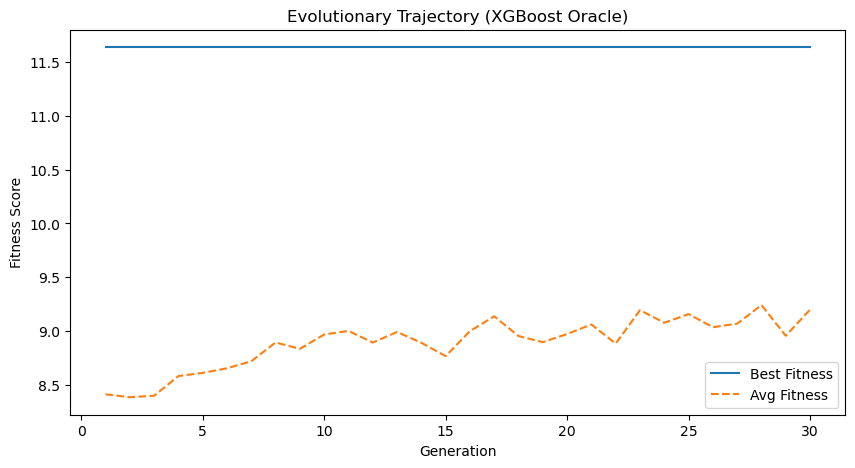

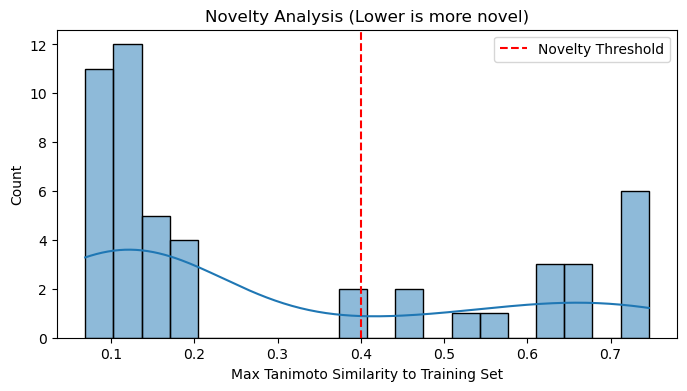

Wyniki zapisane. Teraz czas na dokowanie!


In [10]:
# 1. Wykres postępu ewolucji
hist_df = pd.DataFrame(history)
plt.figure(figsize=(10, 5))
plt.plot(hist_df['gen'], hist_df['best_fitness'], label='Best Fitness')
plt.plot(hist_df['gen'], hist_df['avg_fitness'], label='Avg Fitness', linestyle='--')
plt.xlabel('Generation')
plt.ylabel('Fitness Score')
plt.title('Evolutionary Trajectory (XGBoost Oracle)')
plt.legend()
plt.show()



# 2. Analiza Novelty (Tanimoto Similarity do zbioru treningowego)
# Sprawdzamy, czy GA nie odtwarza po prostu danych treningowych
train_fps = [get_fp(s) for s in df_clean['SMILES']]
generated_smiles = [p['smiles'] for p in population[:50]] # Top 50 wygenerowanych

novelty_scores = []
for gen_smi in generated_smiles:
    gen_fp = get_fp(gen_smi)
    # Obliczamy podobieństwo do wszystkich cząsteczek treningowych i bierzemy maksimum
    sims = DataStructs.BulkTanimotoSimilarity(AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(gen_smi), 2, 2048), 
                                              [AllChem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s), 2, 2048) for s in df_clean['SMILES'][:1000]]) # Próbka dla szybkości
    max_sim = max(sims)
    novelty_scores.append(max_sim)

plt.figure(figsize=(8, 4))
sns.histplot(novelty_scores, bins=20, kde=True)
plt.xlabel('Max Tanimoto Similarity to Training Set')
plt.title('Novelty Analysis (Lower is more novel)')
plt.axvline(x=0.4, color='r', linestyle='--', label='Novelty Threshold')
plt.legend()
plt.show()

# 3. Eksport do CSV dla Dokowania
res_df = pd.DataFrame(population)
res_df.to_csv("GA_Results_XGBoost.csv", index=False)
print("Wyniki zapisane. Teraz czas na dokowanie!")

In [11]:
# ==========================================
# BENCHMARK 2: RANDOM FOREST (BASELINE)
# ==========================================
from sklearn.ensemble import RandomForestRegressor

print("--- ROZPOCZYNAM BENCHMARK: RANDOM FOREST ---")

# 1. Optymalizacja Random Forest (jest prostsza niż XGBoost)
def objective_rf(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'max_depth': trial.suggest_int('max_depth', 5, 20),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 5),
        'n_jobs': -1
    }
    
    model = RandomForestRegressor(**param, random_state=SEED)
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = -cross_val_score(model, X, y, cv=kf, scoring='neg_root_mean_squared_error')
    return np.mean(scores)

print("Optymalizacja hiperparametrów Random Forest...")
study_rf = optuna.create_study(direction='minimize')
study_rf.optimize(objective_rf, n_trials=20) # W publikacji: 50

print(f"Najlepsze RMSE (RF): {study_rf.best_value:.4f}")

# 2. Trenowanie finalnego modelu RF
# UWAGA: Nadpisujemy zmienną 'oracle_model' - teraz "Sędzią" jest Random Forest
oracle_model = RandomForestRegressor(**study_rf.best_params, random_state=SEED, n_jobs=-1)
oracle_model.fit(X, y)
print("Sędzia (Oracle) zmieniony na: RANDOM FOREST")

# 3. Uruchomienie Algorytmu Genetycznego (Ten sam kod, ale z nowym sędzią)
# Resetujemy populację, żeby startować z tego samego punktu co XGBoost
population = []
for sm in initial_smiles: # initial_smiles zdefiniowaliśmy wcześniej
    # Przeliczamy fitness, bo nowy model może dawać inne oceny!
    fit, pic, qed = get_fitness(sm) 
    population.append({'smiles': sm, 'fitness': fit, 'pic50': pic, 'gen': 0})

population = sorted(population, key=lambda x: x['fitness'], reverse=True)
history_rf = [] 

print("Start ewolucji (RF)...")
for gen in range(1, GENERATIONS + 1):
    new_population = population[:int(POP_SIZE * 0.1)] # Elityzm
    
    while len(new_population) < POP_SIZE:
        parent1 = random.choice(population[:50])
        parent2 = random.choice(population[:50])
        
        if random.random() < 0.5:
            child_s = crossover_selfie(sf.encoder(parent1['smiles']), sf.encoder(parent2['smiles']))
        else:
            child_s = mutate_selfie(sf.encoder(parent1['smiles']))
            
        try:
            child_smiles = sf.decoder(child_s)
            fit, pic, qed = get_fitness(child_smiles)
            if fit > -1 and child_smiles not in [p['smiles'] for p in new_population]:
                new_population.append({'smiles': child_smiles, 'fitness': fit, 'pic50': pic, 'gen': gen})
        except: continue
            
    population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)
    best = population[0]
    history_rf.append({'gen': gen, 'best_fitness': best['fitness']})
    print(f"RF Gen {gen} | Best Fit: {best['fitness']:.2f} | pIC50: {best['pic50']:.2f}")

# 4. Zapis wyników
pd.DataFrame(population).to_csv("GA_Results_RandomForest.csv", index=False)
print("Wyniki Random Forest zapisane.")

[I 2026-01-10 14:56:16,276] A new study created in memory with name: no-name-5e63c513-2166-4512-8b45-42a1fb52b364


--- ROZPOCZYNAM BENCHMARK: RANDOM FOREST ---
Optymalizacja hiperparametrów Random Forest...


[I 2026-01-10 14:56:31,853] Trial 0 finished with value: 0.6105888391603715 and parameters: {'n_estimators': 283, 'max_depth': 19, 'min_samples_split': 9, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6105888391603715.
[I 2026-01-10 14:56:44,352] Trial 1 finished with value: 0.6129406585025257 and parameters: {'n_estimators': 247, 'max_depth': 20, 'min_samples_split': 2, 'min_samples_leaf': 5}. Best is trial 0 with value: 0.6105888391603715.
[I 2026-01-10 14:56:52,828] Trial 2 finished with value: 0.6491063496062317 and parameters: {'n_estimators': 256, 'max_depth': 7, 'min_samples_split': 10, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6105888391603715.
[I 2026-01-10 14:57:00,147] Trial 3 finished with value: 0.6106162938820774 and parameters: {'n_estimators': 147, 'max_depth': 16, 'min_samples_split': 5, 'min_samples_leaf': 3}. Best is trial 0 with value: 0.6105888391603715.
[I 2026-01-10 14:57:03,158] Trial 4 finished with value: 0.6116638320656264 and parameters: 

Najlepsze RMSE (RF): 0.6073
Sędzia (Oracle) zmieniony na: RANDOM FOREST
Start ewolucji (RF)...
RF Gen 1 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 2 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 3 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 4 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 5 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 6 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 7 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 8 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 9 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 10 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 11 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 12 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 13 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 14 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 15 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 16 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 17 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 18 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 19 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 20 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 21 | Best Fit: 11.79 | pIC50: 6.96
RF Gen 22 | Best Fit: 11.79 | pI

In [12]:
# ==========================================
# BENCHMARK 3: MLP (NEURAL NETWORK)
# ==========================================
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

print("--- ROZPOCZYNAM BENCHMARK: MLP (SIECI NEURONOWE) ---")

# Sieci neuronowe WYMAGAJĄ skalowania danych (fingerprinty to 0/1, ale i tak warto)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1. Optymalizacja MLP
def objective_mlp(trial):
    param = {
        'hidden_layer_sizes': trial.suggest_categorical('hidden_layer_sizes', [(100,), (200, 100), (512, 128)]),
        'activation': 'relu',
        'solver': 'adam',
        'alpha': trial.suggest_float('alpha', 1e-5, 1e-2, log=True), # Regularyzacja L2
        'learning_rate_init': trial.suggest_float('learning_rate_init', 1e-4, 1e-2, log=True),
        'max_iter': 500
    }
    
    model = MLPRegressor(**param, random_state=SEED)
    kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
    scores = -cross_val_score(model, X_scaled, y, cv=kf, scoring='neg_root_mean_squared_error')
    return np.mean(scores)

print("Optymalizacja hiperparametrów MLP...")
study_mlp = optuna.create_study(direction='minimize')
study_mlp.optimize(objective_mlp, n_trials=20)

print(f"Najlepsze RMSE (MLP): {study_mlp.best_value:.4f}")

# 2. Trenowanie finalnego modelu MLP
oracle_model = MLPRegressor(**study_mlp.best_params, random_state=SEED, max_iter=1000)
oracle_model.fit(X_scaled, y)
print("Sędzia (Oracle) zmieniony na: MLP NEURAL NET")

# ! WAŻNE ! 
# Musimy lekko zmienić funkcję predykcji, żeby używała skalowania (X_scaled)
# Nadpisujemy funkcję globalną tylko na potrzeby tej komórki i pętli GA
original_predict_pic50 = predict_pic50 # Kopia zapasowa

def predict_pic50(smiles):
    try:
        fp = get_fp(smiles).reshape(1, -1)
        # Skalujemy fingerprint przed podaniem do sieci!
        fp_scaled = scaler.transform(fp)
        return oracle_model.predict(fp_scaled)[0]
    except:
        return 0.0

# 3. Uruchomienie Algorytmu Genetycznego (Dla MLP)
population = []
for sm in initial_smiles:
    fit, pic, qed = get_fitness(sm) 
    population.append({'smiles': sm, 'fitness': fit, 'pic50': pic, 'gen': 0})

population = sorted(population, key=lambda x: x['fitness'], reverse=True)
history_mlp = []

print("Start ewolucji (MLP)...")
for gen in range(1, GENERATIONS + 1):
    new_population = population[:int(POP_SIZE * 0.1)]
    while len(new_population) < POP_SIZE:
        parent1 = random.choice(population[:50])
        parent2 = random.choice(population[:50])
        
        if random.random() < 0.5:
            child_s = crossover_selfie(sf.encoder(parent1['smiles']), sf.encoder(parent2['smiles']))
        else:
            child_s = mutate_selfie(sf.encoder(parent1['smiles']))
            
        try:
            child_smiles = sf.decoder(child_s)
            fit, pic, qed = get_fitness(child_smiles)
            if fit > -1 and child_smiles not in [p['smiles'] for p in new_population]:
                new_population.append({'smiles': child_smiles, 'fitness': fit, 'pic50': pic, 'gen': gen})
        except: continue
            
    population = sorted(new_population, key=lambda x: x['fitness'], reverse=True)
    best = population[0]
    history_mlp.append({'gen': gen, 'best_fitness': best['fitness']})
    print(f"MLP Gen {gen} | Best Fit: {best['fitness']:.2f} | pIC50: {best['pic50']:.2f}")

# 4. Zapis wyników
pd.DataFrame(population).to_csv("GA_Results_MLP.csv", index=False)
print("Wyniki MLP zapisane.")

# Przywracamy starą funkcję (dobra praktyka)
predict_pic50 = original_predict_pic50

[I 2026-01-10 15:00:52,984] A new study created in memory with name: no-name-832ed189-9a33-4e67-b7dc-b9b4a306ccc5


--- ROZPOCZYNAM BENCHMARK: MLP (SIECI NEURONOWE) ---
Optymalizacja hiperparametrów MLP...


/home/jakub/anaconda3/envs/ml4dd2025/lib/python3.10/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (100,) which is of type tuple.
  warnings.warn(message)
/home/jakub/anaconda3/envs/ml4dd2025/lib/python3.10/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (200, 100) which is of type tuple.
  warnings.warn(message)
/home/jakub/anaconda3/envs/ml4dd2025/lib/python3.10/site-packages/optuna/distributions.py:502: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains (512, 128) which is of type tuple.
  warnings.warn(message)
[I 2026-01-10 15:01:04,073] Trial 0 finished with value: 0.9288526700584822 and parameters: {'hidden_layer_sizes': (200

Najlepsze RMSE (MLP): 0.8525
Sędzia (Oracle) zmieniony na: MLP NEURAL NET
Start ewolucji (MLP)...
MLP Gen 1 | Best Fit: 12.20 | pIC50: 7.13
MLP Gen 2 | Best Fit: 13.18 | pIC50: 7.85
MLP Gen 3 | Best Fit: 13.18 | pIC50: 7.85
MLP Gen 4 | Best Fit: 13.98 | pIC50: 8.40
MLP Gen 5 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 6 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 7 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 8 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 9 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 10 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 11 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 12 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 13 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 14 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 15 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 16 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 17 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 18 | Best Fit: 15.87 | pIC50: 9.61
MLP Gen 19 | Best Fit: 15.97 | pIC50: 9.63
MLP Gen 20 | Best Fit: 15.97 | pIC50: 9.63
MLP Gen 21 | Best Fit: 15.97 | pIC50: 9.63
MLP Gen 

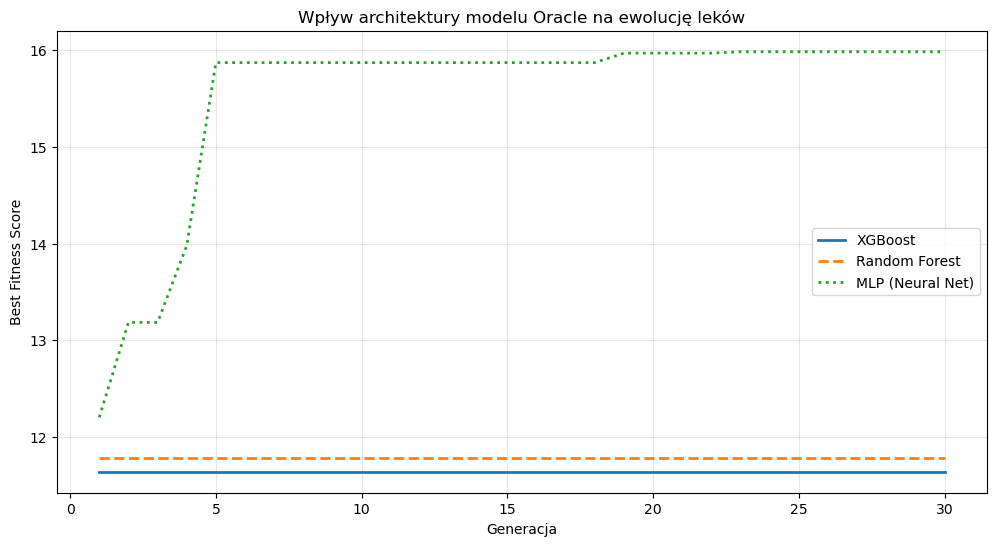

To jest wykres, który wstawisz do Fig. 3 w publikacji!


In [13]:
# ==========================================
# PODSUMOWANIE: PORÓWNANIE METOD
# ==========================================

plt.figure(figsize=(12, 6))

# Zakładam, że w pierwszej komórce GA zapisałeś historię do listy 'history'
# Jeśli nie, musisz tam dodać: history_xgb = history
# Poniżej przykład, jak to narysować, mając listy z każdej komórki

# Dane XGBoost (zakładam, że nazwałeś listę 'history' w pierwszej sekcji GA)
gens_xgb = [x['gen'] for x in history] 
fits_xgb = [x['best_fitness'] for x in history]

# Dane Random Forest
gens_rf = [x['gen'] for x in history_rf]
fits_rf = [x['best_fitness'] for x in history_rf]

# Dane MLP
gens_mlp = [x['gen'] for x in history_mlp]
fits_mlp = [x['best_fitness'] for x in history_mlp]

plt.plot(gens_xgb, fits_xgb, label='XGBoost', linewidth=2)
plt.plot(gens_rf, fits_rf, label='Random Forest', linewidth=2, linestyle='--')
plt.plot(gens_mlp, fits_mlp, label='MLP (Neural Net)', linewidth=2, linestyle=':')

plt.xlabel('Generacja')
plt.ylabel('Best Fitness Score')
plt.title('Wpływ architektury modelu Oracle na ewolucję leków')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print("To jest wykres, który wstawisz do Fig. 3 w publikacji!")